# Parcial 3

### Enunciados Punto 1

Considere las bases de datos del petróleo brent (con nombre __petroleo_brent_historico.csv__) y de la tasa representativa del mercado (__trm_historico.csv__) que se encuentran en la carpeta DATOS del Google Drive.

1. Lea ambas bases de datos.

2. Una las dos bases de datos en una sola BD.

3. Realice un gráfico donde aparezcan ambas series de tiempo.

4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.

7. Encuentre un modelo con la función __auto_arima__ para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.

8. Realice un diagnóstico del modelo y saque conclusiones.

9. Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

10. Saque conclusiones.

## 1. Lea ambas bases de datos.

In [298]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
 
import pmdarima as pmd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')

In [299]:
df = pd.read_csv("../data/petroleo_brent_historico.csv", decimal=",")
dolar = pd.read_csv("../data/trm_historico.csv")

In [300]:
df.Fecha = pd.to_datetime(df.Fecha, format="%d.%m.%Y")

In [301]:
df["fecha"] = df.Fecha
df["petroleo"] = df["Último"]

In [302]:
df = df[["fecha", "petroleo"]]

In [303]:
df.head()

,fecha,petroleo
0,2022-03-14,106.90
1,2022-03-11,112.67
2,2022-03-10,109.33
3,2022-03-09,111.14
4,2022-03-08,127.98


In [304]:
dolar.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,2850.98,COP,09/10/2002,09/10/2002
1,2854.04,COP,10/10/2002,10/10/2002
2,2870.63,COP,11/10/2002,11/10/2002
3,2861.16,COP,12/10/2002,15/10/2002
4,2852.99,COP,16/10/2002,16/10/2002


In [305]:
dolar["fecha"] = pd.to_datetime(dolar.VIGENCIADESDE, format="%d/%m/%Y")
dolar["dolar"] = dolar.VALOR

In [306]:
dolar = dolar[["fecha", "dolar"]]

## 2. Una las dos bases de datos en una sola BD.

In [307]:
df = df.merge(dolar, on='fecha', how='left')
df = df.dropna()

In [308]:
df = df.sort_values(by=['fecha'])

## 3. Realice un gráfico donde aparezcan ambas series de tiempo.

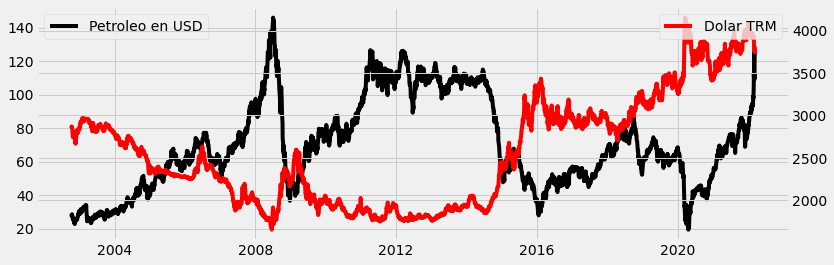

In [309]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.plot(df.fecha, df.petroleo, color="black", label="Petroleo en USD")
ax2.plot(df.fecha, df.dolar, color="red", label="Dolar TRM")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

## 4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

In [357]:
import statsmodels.api as sm

In [351]:
df_2 = df.copy()

In [352]:
df_2["tendencia"] = list(range(0, 3632 + 1))

In [369]:
df_2["mes"] = df.fecha.dt.month

In [370]:
df_2["lag12"] = df.dolar.diff(periods = 12)

In [371]:
df_2 = df_2.dropna()
mod_l = sm.OLS(df_2[["dolar"]], df_2[["tendencia", "mes", "lag12"]])

res = mod_l.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dolar   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              9910.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):                        0.00
Time:                        17:38:19   Log-Likelihood:                         -29637.
No. Observations:                3621   AIC:                                  5.928e+04
Df Residuals:                    3618   BIC:                                  5.930e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Se observa correlación entre el mes y la serie y no se presenta correlación de la serie con su valor 12 dias atras, por esta razon podria ser innecesario usar un Seasonal ARIMA.**

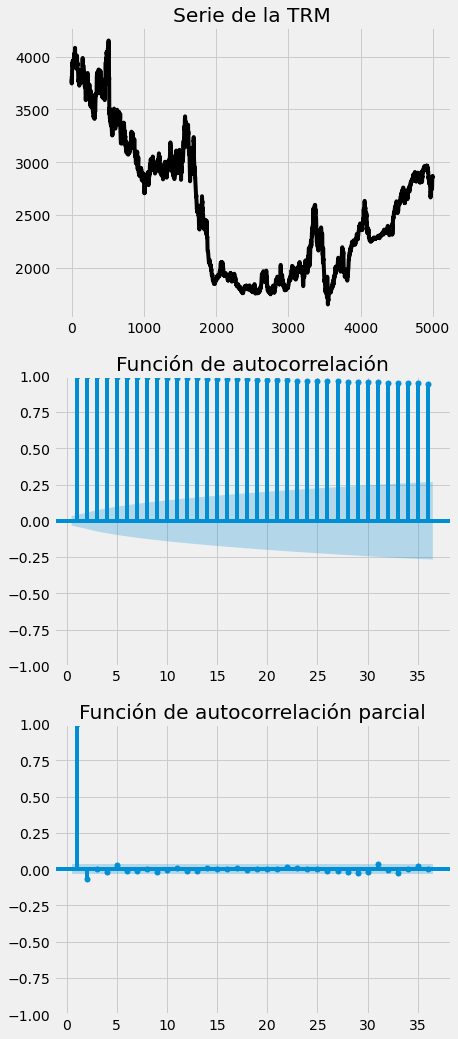

In [310]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
df.dolar.plot(ax=ax[0], title = "Serie de la TRM", xlabel="", color="black")
plot_acf(df.dolar, zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(df.dolar, method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

Del gráfico de la serie de tiempo no se observa que sea estacionaria, procedemos a observar la función de autocorrelación la cual presenta un decaimiento demasiado lento, por lo cual nos da indicios de que debemos de realizar una diferenciación.

Se realizará una prueba de Dickey-Fuller para verificar si es necesario realizar una diferenciación.

In [311]:
test = adfuller(df.dolar)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -0.4943040666
p-value: 	 	 0.8931232351189349


Observando el p-valor = 0.8931232351189345 y con una significancia de $\alpha = 0.05$ no se rechaza. Esto quiere decir que no hay estacionaridad en la serie, lo que nos indica que debemos realizar una diferenciación.

Procedemos a diferenciar la serie. 

In [312]:
dolar_diff = df.dolar.diff()
dolar_diff

4999      NaN
4998     3.06
4997    16.59
4994   -17.64
4993     4.14
        ...  
6      -91.18
4       41.64
3      -26.23
2      -40.75
1       39.57
Name: dolar, Length: 3637, dtype: float64

In [313]:
dolar_diff = dolar_diff[-dolar_diff.isna()]
dolar_diff

4998     3.06
4997    16.59
4994   -17.64
4993     4.14
4992    -3.23
        ...  
6      -91.18
4       41.64
3      -26.23
2      -40.75
1       39.57
Name: dolar, Length: 3636, dtype: float64

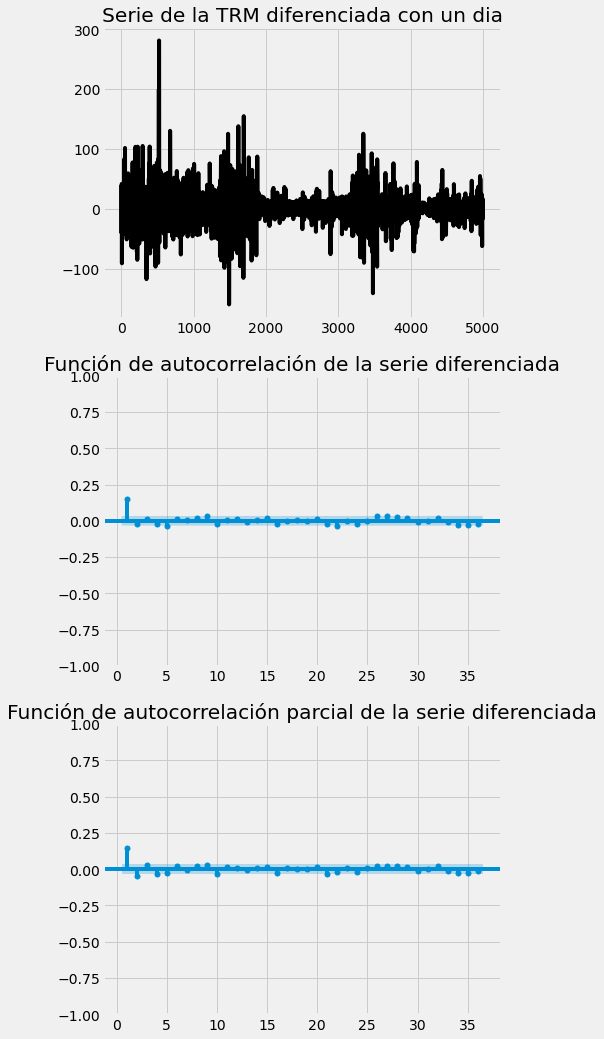

In [314]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
dolar_diff.plot(ax=ax[0], title = "Serie de la TRM diferenciada con un dia", xlabel="", color="black")
plot_acf(dolar_diff, zero = False, title = "Función de autocorrelación de la serie diferenciada", ax=ax[1])
plot_pacf(dolar_diff, method="ywm", zero = False, title = "Función de autocorrelación parcial de la serie diferenciada", ax=ax[2])
fig.show()

In [315]:
test = adfuller(dolar_diff)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -27.498891546
p-value: 	 	 0.0


Observando el p-valor es menor a 0.05 por se rechaza la hipotesis nula. Esto quiere decir que hay estacionaridad en la serie con una diferenciación.

Despues de realizar la diferenciación se ve que en la ACF hay un corte en el Lag 1 y en la PACF hay un corte en el Lag 1 o 2, se entrenaran varios modelos.

In [316]:
pdq_l = [(p, 1, q) for p in [0, 1, 2, 3] for q in [0, 1, 2, 3]] # ARIMA(0:3, 1, 0:3)

In [317]:
filas = []
for order in pdq_l:
    fit = ARIMA(df.dolar, order=order).fit()
    aic = fit.aic
    bic = fit.bic
    filas.append([order, aic, bic])
filas

[[(0, 1, 0), 33295.1498032477, 33301.348442703],
 [(0, 1, 1), 33210.503851841735, 33222.90113075233],
 [(0, 1, 2), 33209.39997263503, 33227.99589100092],
 [(0, 1, 3), 33210.232801177845, 33235.02735899903],
 [(1, 1, 0), 33216.98773474664, 33229.38501365724],
 [(1, 1, 1), 33208.72846473918, 33227.32438310507],
 [(1, 1, 2), 33210.57747772448, 33235.37203554567],
 [(1, 1, 3), 33212.19433232851, 33243.187529605],
 [(2, 1, 0), 33211.57354238894, 33230.169460754834],
 [(2, 1, 1), 33210.53251436929, 33235.32707219048],
 [(2, 1, 2), 33212.7008982697, 33243.69409554619],
 [(2, 1, 3), 33190.79584411568, 33227.987680847466],
 [(3, 1, 0), 33211.12563695114, 33235.92019477233],
 [(3, 1, 1), 33212.05382796867, 33243.04702524516],
 [(3, 1, 2), 33214.53193918207, 33251.72377591385],
 [(3, 1, 3), 33210.302521184945, 33253.692997372025]]

Nos decidimos a usar el modelo p = 0, d = 1, q = 2 ya que es el que tiene mejor (AIC, BIC) y ademas no tiene muchos parametros.

In [318]:
df = df.reset_index(drop = True)

In [319]:
df

,fecha,petroleo,dolar
0,2002-10-09,28.13,2850.98
1,2002-10-10,27.74,2854.04
2,2002-10-11,27.99,2870.63
3,2002-10-16,28.58,2852.99
4,2002-10-17,27.97,2857.13
...,...,...,...
3632,2022-03-04,118.11,3771.77
3633,2022-03-08,127.98,3813.41
3634,2022-03-09,111.14,3787.18
3635,2022-03-10,109.33,3746.43


In [ ]:
df_2[["dolar"]], df_2[["tendencia", "mes", "lag12"]]

In [320]:
fit = ARIMA(df.dolar, order=(0,1,2)).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  dolar   No. Observations:                 3637
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -16601.700
Date:                Tue, 08 Nov 2022   AIC                          33209.400
Time:                        16:19:36   BIC                          33227.996
Sample:                             0   HQIC                         33216.024
                               - 3637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1565      0.011     14.573      0.000       0.135       0.178
ma.L2         -0.0293      0.011     -2.790      0.005      -0.050      -0.009
sigma2       541.1635      5.127    105.559      0.000     531.115     551.212
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18711.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5. Realice un diagnóstico del modelo y saque conclusiones.

In [321]:
sm.stats.acorr_ljungbox(fit.resid, lags=range(1, 10 + 1), return_df=True)

,lb_stat,lb_pvalue
1,0.001422,0.969921
2,0.096955,0.952679
3,0.119411,0.989410
4,0.132798,0.997891
5,0.375526,0.995977
6,1.063703,0.983082
7,1.240123,0.989974
8,1.247255,0.996153
9,1.480130,0.997292
10,1.480764,0.998994


Como se puede observar en la tabla anterior, para los lags de 1 al 10 no se rechaza la hipótesis nula, esto quiere decir que hay una evidencia fuerte en contra de la hipótesis alternativa de correlación entre los errores. 

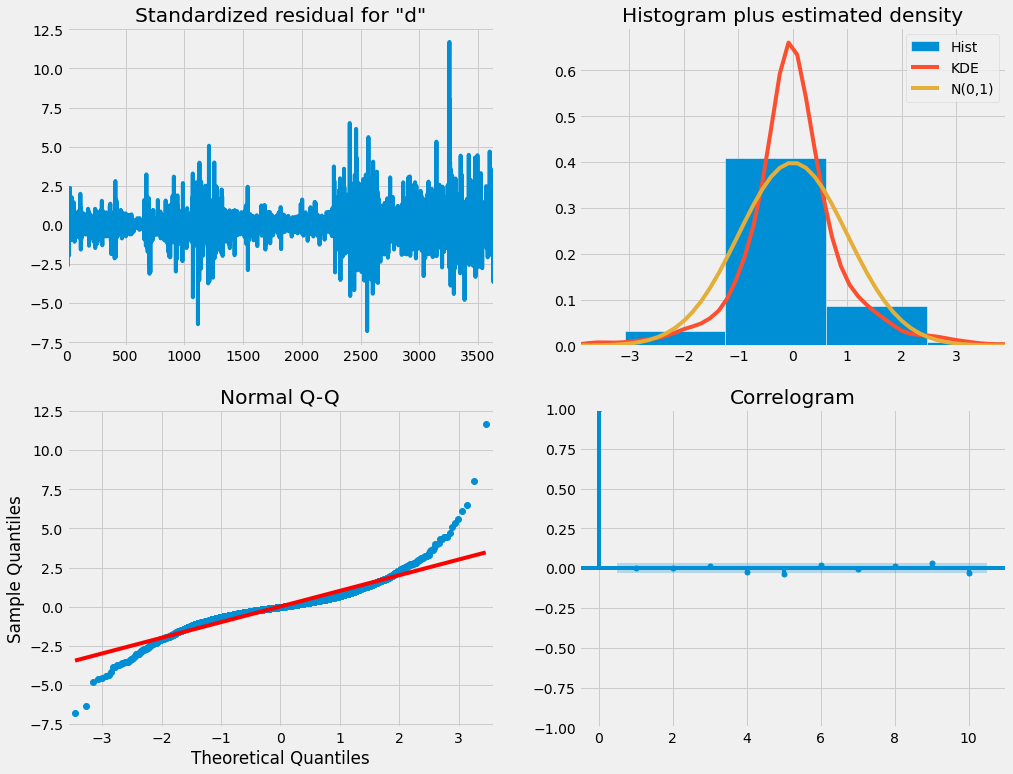

In [322]:
fit.plot_diagnostics(figsize=(15,12))
plt.show()

Como se puede ver en el **summary** del punto anterior el modelo no cumple la normalidad en los errores, se intentaron varios modelos pero ninguno cumple normalidad, a pesar de esto el modelo se puede usar pero teniendo en cuenta que no se deben realizar predicciones muchos dias hacia el futuro. 

## 6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.



In [324]:
df = df.dropna().reset_index(drop = True)

Creo la variable **pct_change** que es el cambio porcentual entre el precio del dia actual vs el precio de hace 7 dias.

In [325]:
df["pct_change_1"] = df.petroleo.pct_change(periods = 1)
df["pct_change_2"] = df.petroleo.pct_change(periods = 2)
df["pct_change_3"] = df.petroleo.pct_change(periods = 3)
df["pct_change_4"] = df.petroleo.pct_change(periods = 4)

In [326]:
df = df.dropna().reset_index(drop = True)

In [327]:
df_len = df.shape[0]
df_len # numero de filas

3633

In [328]:
train = df[:(df_len - 10)]
test = df[(df_len - 10):]
test

,fecha,petroleo,dolar,pct_change_1,pct_change_2,pct_change_3,pct_change_4
3623,2022-02-24,99.08,3913.79,0.023131,0.059226,0.065720,0.045037
3624,2022-02-25,97.93,3940.20,-0.011607,0.011256,0.046932,0.053351
3625,2022-03-01,104.97,3910.28,0.071888,0.059447,0.083953,0.122194
3626,2022-03-02,112.93,3901.62,0.075831,0.153171,0.139786,0.166150
3627,2022-03-03,110.46,3862.95,-0.021872,0.052301,0.127949,0.114857
3628,2022-03-04,118.11,3771.77,0.069256,0.045869,0.125179,0.206066
3629,2022-03-08,127.98,3813.41,0.083566,0.158609,0.133268,0.219205
3630,2022-03-09,111.14,3787.18,-0.131583,-0.059013,0.006156,-0.015851
3631,2022-03-10,109.33,3746.43,-0.016286,-0.145726,-0.074337,-0.010230
3632,2022-03-11,112.67,3786.00,0.030550,0.013766,-0.119628,-0.046059


In [329]:
test

,fecha,petroleo,dolar,pct_change_1,pct_change_2,pct_change_3,pct_change_4
3623,2022-02-24,99.08,3913.79,0.023131,0.059226,0.065720,0.045037
3624,2022-02-25,97.93,3940.20,-0.011607,0.011256,0.046932,0.053351
3625,2022-03-01,104.97,3910.28,0.071888,0.059447,0.083953,0.122194
3626,2022-03-02,112.93,3901.62,0.075831,0.153171,0.139786,0.166150
3627,2022-03-03,110.46,3862.95,-0.021872,0.052301,0.127949,0.114857
3628,2022-03-04,118.11,3771.77,0.069256,0.045869,0.125179,0.206066
3629,2022-03-08,127.98,3813.41,0.083566,0.158609,0.133268,0.219205
3630,2022-03-09,111.14,3787.18,-0.131583,-0.059013,0.006156,-0.015851
3631,2022-03-10,109.33,3746.43,-0.016286,-0.145726,-0.074337,-0.010230
3632,2022-03-11,112.67,3786.00,0.030550,0.013766,-0.119628,-0.046059


Utilizaremos solo 10 datos (2 semanas bursatiles) para el conjunto de prueba, ya que estos modelos usualmente no se usan para predecir muchos días en el futuro debido a la volatilidad, eventos inesperados y manipulación que estas series presentan.



Los datos de entrenamiento tienen 3623 filas (0 a 3622), los datos de prueba tienen 10 filas (3623 a 3632). 

## 7. Encuentre un modelo con la función auto_arima para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.


In [330]:
exo_var = ["petroleo", "pct_change_1", "pct_change_2", "pct_change_3", "pct_change_4"]
fit_X = pmd.arima.auto_arima(y = train["dolar"], X = train[exo_var])

In [331]:
fit_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3623
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -16452.799
Date:                Tue, 08 Nov 2022   AIC                          32921.599
Time:                        16:20:03   BIC                          32971.157
Sample:                             0   HQIC                         32939.255
                               - 3623                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
petroleo        -3.5146      0.313    -11.212      0.000      -4.129      -2.900
pct_change_1   161.3761     10.577     15.258      0.000     140.646     182.106
pct_change_2    42.2280     10.307      4.097      0.000      22.027      62.429
pct_change_3    -7.5367      9.736     -0.774      0.439     -26.618      11.545
pct_change_4   -34.8202     10.024     -3.474      0.001     -54.467     -15.173
ma.L1            0.1281      0.010     12.359      0.000       0.108       0.148
ma.L2           -0.0378      0.010     -3.606      0.000      -0.058      -0.017
sigma2         516.4143      5.857     88.174      0.000     504.935     527.893
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15891.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.64   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se puede observar que todas parecen ser significativas menos el cambio porcentual tres dias atras.

In [332]:
pred_X, pred_ci = fit_X.predict(n_periods=10, X = test[exo_var], return_conf_int=True)

A continuación se observan los 7 valores al futuro predichos por el modelo.

In [333]:
print(pred_X)

3623    3921.755556
3624    3918.472402
3625    3906.562766
3626    3881.229491
3627    3871.759264
3628    3856.152019
3629    3828.014841
3630    3852.433229
3631    3874.150057
3632    3878.293465
dtype: float64


## 8. Realice un diagnóstico del modelo y saque conclusiones.

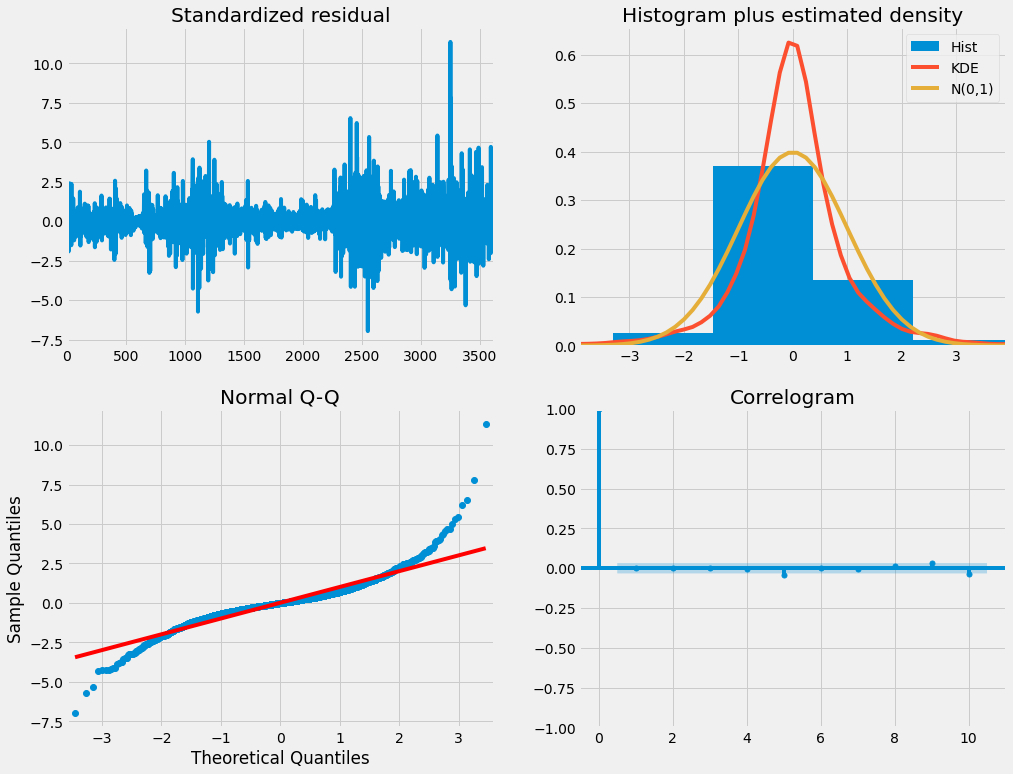

In [334]:
fit_X.plot_diagnostics(figsize=(15,12))
plt.show()

In [335]:
sm.stats.acorr_ljungbox(fit_X.resid())

,lb_stat,lb_pvalue
1,0.009237,0.923435
2,1.059222,0.588834
3,1.378478,0.710587
4,1.454721,0.834631
5,1.560442,0.905991
6,1.664220,0.947850
7,1.665275,0.976031
8,1.665276,0.989612
9,1.933196,0.992480
10,2.095771,0.995552


Como se puede observar en el punto anterior se rechaza la normalidad de los errores y ademas se observa que no hay correlacion entre los errores del Lag 1 al 10.

## 9 . Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

In [336]:
pred_no_X = fit.predict(start = 3623, end = 3632)#3626 a 3632

- pred_X = Predicción hecha con variables exógenas.
- pred_no_X = Predicción hecha sin variables exógenas
- test.dolar = Valor real de la serie de prueba

In [337]:
pred_no_X

3623    3943.112559
3624    3946.789943
3625    3966.259805
3626    3950.728760
3627    3929.911857
3628    3911.803527
3629    3945.117748
3630    3903.994145
3631    3902.269502
3632    3856.864507
Name: predicted_mean, dtype: float64

In [338]:
pred_X

3623    3921.755556
3624    3918.472402
3625    3906.562766
3626    3881.229491
3627    3871.759264
3628    3856.152019
3629    3828.014841
3630    3852.433229
3631    3874.150057
3632    3878.293465
dtype: float64

In [339]:
test.dolar

3623    3913.79
3624    3940.20
3625    3910.28
3626    3901.62
3627    3862.95
3628    3771.77
3629    3813.41
3630    3787.18
3631    3746.43
3632    3786.00
Name: dolar, dtype: float64

In [340]:
MSE_X = mean_squared_error(test.dolar, pred_X)
MSE_no_X = mean_squared_error(test.dolar, pred_no_X)
MAPE_X = mean_absolute_percentage_error(test.dolar, pred_X)
MAPE_no_X = mean_absolute_percentage_error(test.dolar, pred_no_X)

print("Root Mean Square Error:")
print("- con variables exógenas " + str(math.sqrt(MSE_X)))
print("- sin variables exógenas " + str(math.sqrt(MSE_no_X)))

print("\n")
print("MAPE:")
print("- con variables exógenas " + str(MAPE_X*100))
print("- sin variables exógenas " + str(MAPE_no_X*100))

Root Mean Square Error:
- con variables exogenas 61.20852850850137
- sin variables exogenas 95.3111386778927


MAPE:
- con variables exogenas 1.1790743099220422
- sin variables exogenas 2.162255385704585


## 10. Saque conclusiones.

Se puede ver que con el **modelo entrenado inicialmente (sin variables exógenas)** se obtiene un **RMSE de 95.31 y un MAPE de 2.16**, mientras que cuando se consideran las **variables exógenas** de precio de petróleo y cambio porcentual respecto a días anteriores, se observa un **RMSE de 61.20 y un MAPE de 1.17**, esto es una reducción en el error de **alrededor del 50%**.

Si se tiene en cuenta que el dólar para la cola de esta base de datos toma valores alrededor de 3800, un RMSE de 61 se puede considerar aceptable o muy buena, depende mucho del uso que se le vaya a dar a estas predicciones. También se puede observar que agregar las variables exógenas si tuvo mejoría en las predicciones.

